# Translation to Rotation Models

In [1]:
from obspy import * 
from pandas import *
from os import listdir

import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
if os.uname().nodename == "lighthouse":
    root_path = "/home/andbro/"
    data_path = "/home/andbro/kilauea-data/"
    archive_path = "/home/andbro/freenas/"
elif os.uname().nodename == "kilauea":
    root_path = "/home/brotzer/"
    data_path = "/export/data/"
    archive_path = "/import/freenas-ffb-01-data/"

## Configurations

In [3]:
config = {}

config['workdir'] = f"{data_path}LNM/data/"

config['love_phase_nc'] = "PHASE_VELOCITY_MODEL/LovePhaseVelocity.nc"
config['rayleigh_phase_nc'] = "PHASE_VELOCITY_MODEL/RayleighPhaseVelocity.nc"

config['datadir_spectra'] = config['workdir']+"2018/"

config['spectra_files'] = listdir(config['datadir_spectra'])

config['outdir'] = config['workdir']+"STATS/"

config['period_lower'] = 2.5
config['period_upper'] = 300

## Analyse Dataset 

total stations:  272
unique stations: 144


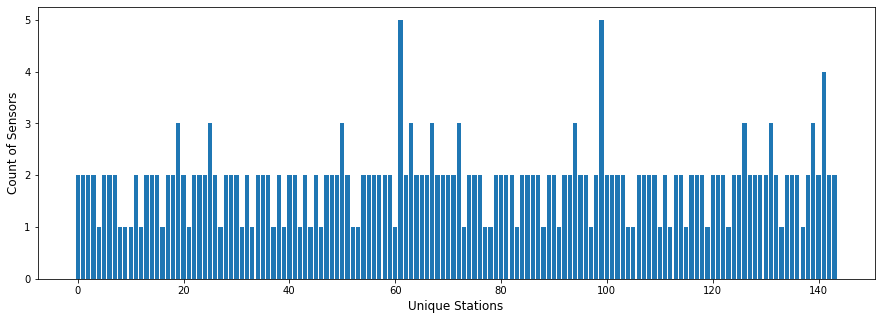

In [4]:
stations = DataFrame()

stations['sta'] = config['spectra_files']

stations['names'] = [s.split("_")[1] for s in stations['sta']]

print(f"total stations:  {stations.names.size}")
print(f"unique stations: {stations.names.unique().size}")

stations['count'] = np.ones(stations.names.size)
new = stations.groupby(by='names')['count'].sum()

plt.figure(figsize=(15,5))
plt.bar(range(new.index.size), height=new)

plt.ylabel("Count of Sensors", fontsize=12)
plt.xlabel("Unique Stations", fontsize=12)

plt.show();

In [5]:
def __read_velocities_nc(path, fname):
    
    print(f"\nreading {path}{fname}")
    
    f = nc.Dataset(str(path)+str(fname),'r')
    
#     for key in f.variables.keys():
#            print(key)
            
#     print(f.dimensions)          
#     print(f.variables['period'][:])
#     print(f.variables['latitude'][:])
#     print(f.variables['longitude'][:])

    vphase = f.variables['vel'][:]
    # vphase.shape (57, 91, 181)
    # 57 periods: 0.1 to 300 sec 
    # on a grid for lon lat
        
    period = f.variables['period']
    
    return vphase, period

In [6]:
vphase, period = __read_velocities_nc(config["workdir"], config["rayleigh_phase_nc"]);

# vphase, period = __read_velocities_nc(config["workdir"], config["love_phase_nc"]);


reading /home/andbro/kilauea-data/LNM/data/PHASE_VELOCITY_MODEL/RayleighPhaseVelocity.nc


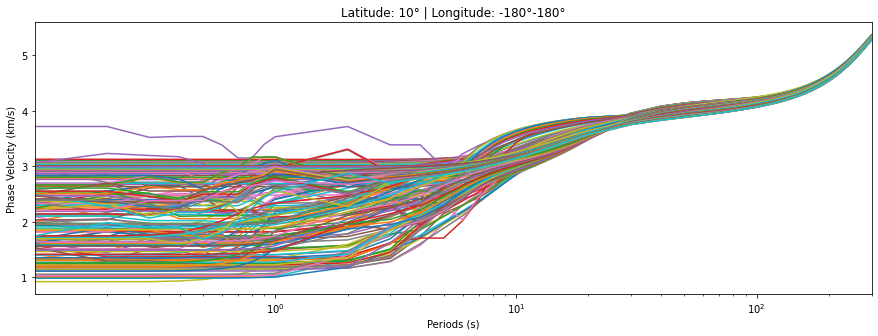

In [7]:
fig, ax = plt.subplots(1,1, figsize=(15,5))

lat_set = 10

for i in range(180):
#     ax.plot(period, vphase[:,2,i])
    ax.semilogx(period, vphase[:,lat_set,i])

ax.set_xlim(period[0], period[-1])

ax.set_xlabel("Periods (s)")
ax.set_ylabel("Phase Velocity (km/s)")

ax.set_title(f"Latitude: {lat_set}° | Longitude: -180°-180°")

plt.show();

### Load spectra of stations

In [8]:
def __read_spectra_nc(path, fname):
    
    print(f"\nreading {path}{fname}")
    
    f = nc.Dataset(str(path)+str(fname),'r')
    
#     for key in f.variables.keys():
#            print(key)
        
    sta = f.variables["trace_id"][:][0].split(".")[1]
    ff = f.variables["frequency"][:]
    ss = f.variables["spectrogram"][:]
    lon = float(f.variables["lon"][:].data)
    lat = float(f.variables["lat"][:].data)
    
    return sta, ff, ss, lon, lat

In [9]:
path = config['datadir_spectra']
fname = "ESACCI-SEASTATE-L2-MSSPEC-IU_YAK_LHZ_00_2018-fv01.nc"

sta, ff, ss, lon, lat = __read_spectra_nc(path, fname)

pp = 1/ff


reading /home/andbro/kilauea-data/LNM/data/2018/ESACCI-SEASTATE-L2-MSSPEC-IU_YAK_LHZ_00_2018-fv01.nc


### Extract velocity profile 

Get velocity profile of station according to coordinates from grid of velocity profiles. Either use velocity profile of nearest grid point or compute velocity profile by inverse distance weigthed sum. Then linearily interpolate for the frequency/period axis of the spectra.

In [10]:
def __get_velocity_profile(vdata, period, lat, lon, mode="nearest", plot=False):

    from numpy import sqrt
    
    if mode is "nearest":
        velocity_profile =  vdata[:,round(lat),round(lon)]

    if mode is "inverse_distance":
        
        def __get_distance(lat_p1,lon_p1, lat_p2,lon_p2):
            return sqrt((lat_p1-lat_p2)**2 + (lon_p1-lon_p2)**2)
            
        lon1, lon2 = int(np.ceil(lon)), int(np.floor(lon))
        lat1, lat2 = int(np.ceil(lat)), int(np.floor(lat))

        lon_w1, lon_w2 = abs(lon1-lon), abs(lon2-lon)
        lat_w1, lat_w2 = abs(lat1-lat), abs(lat2-lat)

        v1 = vphase[:,lat1,lon1]
        v2 = vphase[:,lat2,lon1]
        v3 = vphase[:,lat2,lon2]
        v4 = vphase[:,lat1,lon2]
        
        d1 = __get_distance(lat, lon, lat1, lon1)
        d2 = __get_distance(lat, lon, lat2, lon1)
        d3 = __get_distance(lat, lon, lat2, lon2)
        d4 = __get_distance(lat, lon, lat1, lon2)
        
        velocity_profile = (v1*d1 + v2*d2 + v3*d3 + v4*d4)/(d1+d2+d3+d4)

        if plot:
            plt.plot(period, v1,label="v1")
            plt.plot(period, v2,label="v2")
            plt.plot(period, v3,label="v3")
            plt.plot(period, v4,label="v4")
            plt.plot(period, vv, 'k',label="interp")
            plt.legend()
            plt.show();
        
    return velocity_profile

In [11]:
vv = __get_velocity_profile(vphase, period, lat, lon, mode="inverse_distance", plot=False)

In [12]:
vv_interp = np.interp(pp, period[:], vv)

### Compute statistical measures

Compute median and mean spectra as well as a standard deviation of set of daily power spectra for the station.

In [13]:
def __get_stats(arr, axis=0):

    med, men, std = [],[],[]
    nan_found = False

    for fcross in range(arr.shape[axis]):
        if axis == 0:
            data = arr[fcross,:]
        elif axis == 1:
            data = arr[:,fcross]
        if np.isnan(data).any():
            nan_found = True
            data = data[~np.isnan(data)]
        men.append(np.mean(data))
        med.append(np.median(data))
        std.append(np.std(data))

    if nan_found:
        print(" -> NaN values were detected and ignored!")

    return np.array(med), np.array(men), np.array(std)

In [14]:
med, men, std = __get_stats(ss, axis=0)

### Convert power acceleration to power rotation 

In [15]:
new = np.array(med * ff / vv_interp)
new2 = np.array(med  / vv_interp)

(2.5, 300)

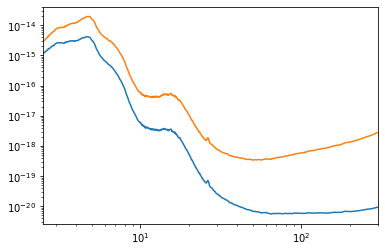

In [16]:

plt.loglog(pp, new)
plt.loglog(pp, new2)

plt.xlim(2.5, 300)

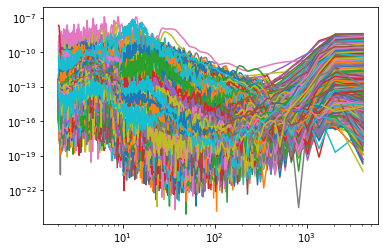

In [17]:
plt.figure()

plt.plot(1/ff, ss)

# plt.plot(1/ff, med, "black")
# plt.fill_between(1/ff, y1=med-std, y2=med+std, color="grey", alpha=0.5)

# plt.plot(1/ff, men, "black")
# plt.fill_between(1/ff, y1=men-std, y2=men+std, color="grey", alpha=0.5)


plt.yscale("log")
plt.xscale("log") 

plt.show();

## Load Stats

In [18]:
medians = read_pickle(config['outdir']+"2018_medians.pkl")
means = read_pickle(config['outdir']+"2018_means.pkl")
deviations = read_pickle(config['outdir']+"2018_deviations.pkl")

deviations

,frequencies,TAU.II,QSPA.IU,SSPA.IU,TARA.IU,WAKE.IU,RPN.II,XMAS.IU,SFJD.IU,JTS.II,...,CAN.G,GNI.IU,CRZF.G,RER.G,OTAV.IU,WRAB.II,IVI.G,PPTF.G,SBA.IU,AIS.G
0,0.000244,17.957025,14.406220,13.826017,15.769182,10.710193,12.175459,20.290739,14.449965,12.402145,...,12.340170,11.828765,10.161995,10.052215,23.179687,10.807522,13.397952,10.424530,10.975785,12.549759
1,0.000488,17.020059,12.763619,11.168052,14.474315,7.738359,9.644232,19.156826,12.389146,10.197626,...,9.341712,9.152416,6.748907,7.211630,23.210952,8.316844,11.125758,7.236029,8.013206,10.020133
2,0.000732,18.815825,12.668595,10.151294,15.737401,7.301675,8.732310,19.297918,11.925531,9.619545,...,8.558198,8.766668,6.601515,6.747724,25.811214,7.926156,10.569669,6.569012,7.733106,9.630438
3,0.000977,20.325584,12.422442,8.978002,18.541802,7.745710,8.101353,18.123769,11.770203,9.300083,...,7.965203,8.929399,6.646418,6.486315,24.719799,8.163681,9.684097,6.410826,8.363573,8.706618
4,0.001221,21.710292,12.211494,8.558118,20.319287,8.142440,7.882146,18.349790,11.829822,9.126442,...,7.793589,8.873070,6.649027,6.471078,25.674341,8.095609,9.303505,6.464763,8.731415,7.754499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,0.488281,36.933690,5.670133,9.135277,9.190078,10.643775,7.399086,27.631107,18.695838,11.026829,...,10.337731,8.047247,10.274436,6.955519,44.983807,9.814407,16.438740,7.219698,13.877796,7.193479
569,0.490723,31.621221,5.548941,8.561972,8.340189,10.017102,7.523046,23.582401,13.806764,9.906337,...,9.237219,7.635931,9.109522,6.771771,37.844982,8.712229,12.910263,7.267235,12.109940,7.124924
570,0.493164,27.778256,5.604025,8.185633,7.289104,9.493366,7.670476,21.748881,14.732370,9.348633,...,8.691153,7.087556,8.938339,6.696413,34.644159,8.411734,12.413851,7.128305,11.156103,6.924659
571,0.495605,24.093804,5.497010,8.017491,6.518976,8.859601,7.468110,19.647364,13.214182,8.948547,...,8.177212,7.127905,8.285014,6.453802,31.008330,7.870324,10.854204,6.970414,10.230362,6.881514


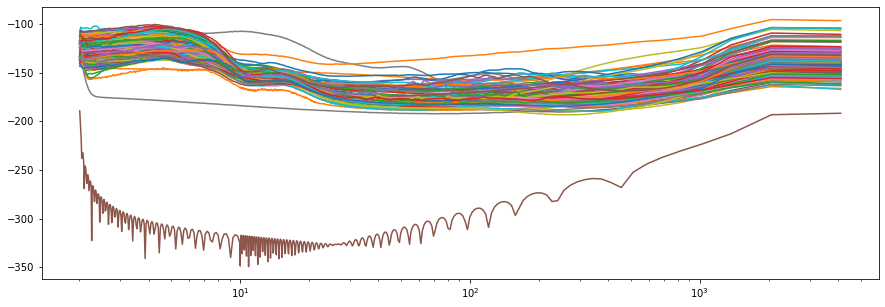

In [19]:
df = medians.copy()

plt.figure(figsize=(15,5))

for sta in df.keys():
    if sta == "frequencies":
        continue
    plt.plot(1/df.frequencies, df[sta])

plt.xscale("log")
plt.show();